In [1]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display, clear_output
from utils.dataset import AdverCityDataset

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
root = r'/home/paulo/Documents/advercity/ui_cd_s'

In [4]:
dataset = AdverCityDataset(root=root, car=0, cam=0)

In [5]:
N = len(dataset)
N

184

In [6]:
detector = cv2.SIFT_create()
# detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
matcher  = cv2.BFMatcher()

In [7]:
poses = []
refs  = []
kp_prev, desc_prev = None, None
for i in range(1, N):
    # Getting sequential frames
    cam_ref_prev, _, cam_extrinsics_prev, cam_image_prev = dataset[i-1]
    cam_ref_curr, cam_intrinsics, _, cam_image_curr      = dataset[i]

    cam_image_prev = np.array(cam_image_prev)[:, :, ::-1]
    cam_image_curr = np.array(cam_image_curr)[:, :, ::-1]

    # Detecting features in both frames
    if kp_prev is None: # and desc_prev is None:
        kp_prev, desc_prev = detector.detectAndCompute(cam_image_prev, None)
    kp_curr, desc_curr = detector.detectAndCompute(cam_image_curr, None)

    # Detecting matched features
    # matches = matcher.match(desc_prev, desc_curr)
    # indices = np.array([[match.queryIdx, match.trainIdx] for match in matches])

    matches = matcher.knnMatch(desc_prev, desc_curr, k=2)
 
    # Apply ratio test
    prev_good_idx = []
    curr_good_idx = []
    for m, n in matches:
        if m.distance < 0.75*n.distance:
            prev_good_idx.append(m.queryIdx)
            curr_good_idx.append(m.trainIdx)

    # Filtering keypoints
    kp_prev_pt = np.array([k.pt for k in kp_prev], dtype=np.float32)
    kp_curr_pt = np.array([k.pt for k in kp_curr], dtype=np.float32)
    # kp_prev_pt = kp_prev_pt[indices[:,0]]
    # kp_curr_pt = kp_curr_pt[indices[:,1]]
    kp_prev_pt = kp_prev_pt[prev_good_idx]
    kp_curr_pt = kp_curr_pt[curr_good_idx]

    # Saving computation time
    kp_prev = kp_curr
    desc_prev = desc_curr

    # Computing Essential matrix
    E, mask = cv2.findEssentialMat(kp_prev_pt, kp_curr_pt, cam_intrinsics, cv2.RANSAC, 0.999, 0.1, 100)
    inliers1 = kp_prev_pt[mask.ravel() > 0]
    inliers2 = kp_curr_pt[mask.ravel() > 0]

    # Recovering pose
    _, R, t, _ = cv2.recoverPose(E, inliers1, inliers2)

    if i == 1:
        # Initializing poses
        poses.append(cam_extrinsics_prev)
        refs.append(cam_ref_prev)
    else:
        # Recovering previous pose
        pose_prev = poses[-1]
        R_prev = pose_prev[:3, :3]

        # Scaling translation with odometer
        distance = cam_ref_curr[-1] * 0.1
        t_scaled = (t * distance).flatten()
        t_world = R_prev.dot([-t_scaled[2], t_scaled[0], t_scaled[1]])

        # Creating relative pose
        pose_rel = np.eye(4)
        pose_rel[:3, :3] = R.T
        pose_rel[:3, 3]  = t_world

        # Creating current pose
        pose_curr = pose_prev @ pose_rel

        # Storing updated pose
        poses.append(pose_curr) 
        refs.append(cam_ref_curr)     

In [8]:
poses = np.array(poses)
poses.shape

(183, 4, 4)

In [9]:
refs = np.array(refs)
refs.shape

(183, 7)

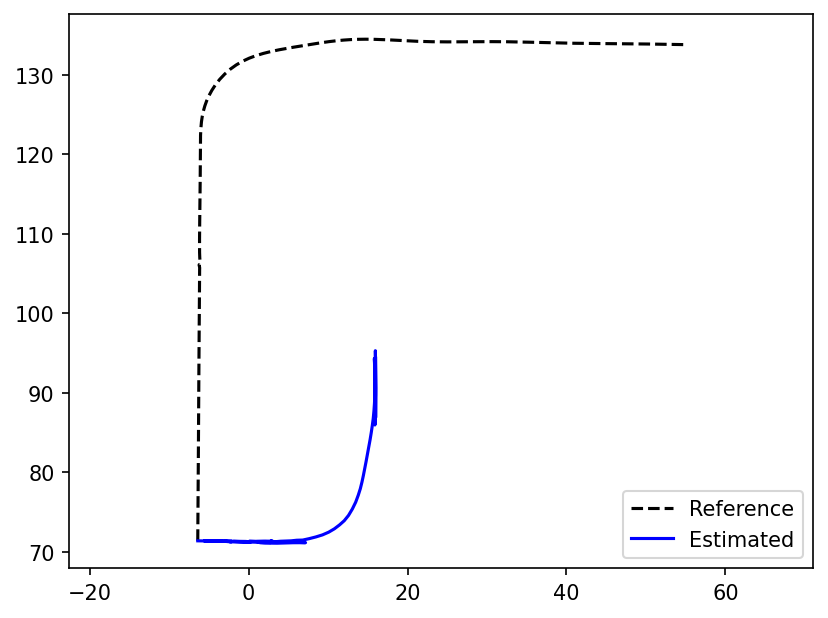

In [10]:
plt.plot(refs[:, 0], refs[:, 1], '--k', label='Reference')
plt.plot(poses[:, 0, 3], poses[:, 1, 3], 'b', label='Estimated')
plt.axis('equal')
plt.legend()
plt.show()